# Q1

In [1]:
import numpy as np
import xarray as xr
import pygrib
from scipy.interpolate import griddata
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.interpolate import interp1d
import statsmodels.api as sm

1) Read the CFSv2 operational forecasts (6-hourly data) initialized at 0000 UTC Nov
2 2021 and calculate the monthly mean T2m forecast in Dec 2021 over a regional
domain (220°E -320°E, 20°N -70°N)

In [2]:
cfsv2_files = "/data/zhuowang/c/zhuowang/Data/CFSv2/2021/flxf2021*.01.2021110200.grb2"
cfsv2_list =  glob.glob(cfsv2_files)
t2m_list = []
# Loop over ethe cfsv2_list
for file  in cfsv2_list:
    grbs = pygrib.open(file)
    t2m = grbs.select(name='2 metre temperature')[0]
    t2m_data = t2m.values
    lats, lons = t2m.latlons()
    grbs.close()
    t2m_tmp = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
    t2m_list.append(t2m_tmp)

t2m_cfsv2 = xr.concat(t2m_list, dim="time").mean(dim="time").\
            sel(lon=slice(220, 320), lat=slice(70, 20))

2) Read latitude and longitude information of T2m over a regional domain (220°E -
320°E, 20°N -70°N) from the CFSR.

In [3]:
file = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas.198012.grb2"
grbs = pygrib.open(file)
t2m = grbs.select(name='2 metre temperature')[0]
t2m_data = t2m.values
lats_new, lons_new = t2m.latlons()
grbs.close()
t2m_cfsr = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats_new[:, 0], 'lon': lons_new[0, :]}).\
            sel(lon=slice(220, 320), lat=slice(70, 20))

(3) The horizonal resolution of the CFSv2 operational forecasts is 1°X1°, and the
horizontal resolution of the CFSR is about 0.31°X0.31°. Please interpolate the
monthly mean CFSv2 forecast of T2m in Dec 2021 to a mesh grid of the same
horizontal resolutions as the CFSR over the domain (220°E -320°E, 20°N -70°N),
and plot the original and interpolated T2m forecasts over North America side by
side.

array([<GeoAxesSubplot: title={'center': 'CFSv2 T2m forecast (Dec 2021) 1x1 degree'}, xlabel='Longitude', ylabel='Latitude'>,
       <GeoAxesSubplot: title={'center': 'CFSv2 T2m forecast (Dec 2021) interpolation 0.3x0.3 degree'}, xlabel='Longitude', ylabel='Latitude'>],
      dtype=object)

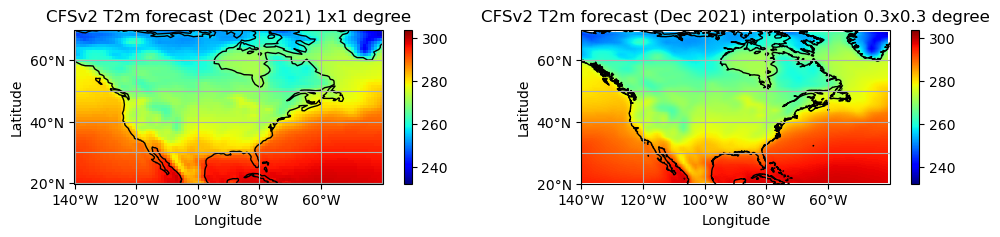

In [4]:
# Use xarray's `interp()` method to interpolate the CFSv2 T2m data to the new grid
t2m_cfsv2_interp = t2m_cfsv2.interp(lat=t2m_cfsr.lat, lon=t2m_cfsr.lon, method='linear')


fig, axs = plt.subplots(1, 2, figsize=(12, 2), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot original T2m forecast
t2m_cfsv2.plot(ax=axs[0], cmap='jet', vmin=232, vmax=304)
axs[0].set_title('CFSv2 T2m forecast (Dec 2021) 1x1 degree')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
xticks = range(-140, -40, 20)
yticks = range(20, 70, 20)
axs[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[0].coastlines()
axs[0].gridlines()

# Plot interpolated T2m forecast
t2m_cfsv2_interp.plot(ax=axs[1], cmap='jet', vmin=232, vmax=304)
axs[1].set_title('CFSv2 T2m forecast (Dec 2021) interpolation 0.3x0.3 degree')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[1].coastlines()
axs[1].gridlines()

axs

# Q2

(1) Read the monthly mean T2m in December during 1982-2010 from the CFSR and
save in a 3D array t2m_o, which is a function of year, latitude and longitude.

In [5]:
t2m_cfsr_list = []
for year in range(1982, 2011):
    cfsr_file_name = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas."+str(year)+"12.grb2"
    grbs = pygrib.open(cfsr_file_name)
    t2m = grbs.select(name='2 metre temperature')[0]
    t2m_data = t2m.values
    lats, lons = t2m.latlons()
    grbs.close()
    t2m_cfsr = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                sel(lon=slice(220, 320), lat=slice(70, 20))
    t2m_cfsr_list.append(t2m_cfsr)


In [6]:
# Create a 3D array t2m_o with dimensions (year, lat, lon)
t2m_o = np.zeros((29, len(t2m_cfsr_list[0].lat), len(t2m_cfsr_list[0].lon)))
for i in range(0,29):
    t2m_o[i, :, :] = t2m_cfsr_list[i]

In [7]:
t2m_o.shape

(29, 160, 320)

(2) Calculate the monthly mean T2m in December using the 6-hourly data from the
CFSv2 reforecasts initiated at 0000 UTC Nov 2 of the same year for each year
from 1982 to 2010, and interpolate the data to the same resolution as the CFSR
data. Denote the 3D array t2m_f, which has the same dimension as t2m_o and is
a function of year, latitude and longitude

In [8]:
file = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas.198012.grb2"
grbs = pygrib.open(file)
t2m = grbs.select(name='2 metre temperature')[0]
t2m_data = t2m.values
lats_new, lons_new = t2m.latlons()
grbs.close()
t2m_cfsr = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats_new[:, 0], 'lon': lons_new[0, :]}).\
            sel(lon=slice(220, 320), lat=slice(70, 20))
t2m_cfsv2_list = []
for year in range(1982, 2011):
    t2m_list = []
    t2m_cfsv2_names = "/data/zhuowang/c/zhuowang/Data/CFSv2/"+str(year)+"/flxf*"
    t2m_cfsv2_list_names = glob.glob(t2m_cfsv2_names)
    # Loop over ethe cfsv2_list
    for file  in t2m_cfsv2_list_names:
        grbs = pygrib.open(file)
        t2m = grbs.select(name='2 metre temperature')[0]
        t2m_data = t2m.values
        lats, lons = t2m.latlons()
        grbs.close()
        t2m_tmp = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
        t2m_list.append(t2m_tmp)

    t2m_cfsv2_list.append(xr.concat(t2m_list, dim="time").mean(dim="time").sel(lon=slice(220, 320), lat=slice(70, 20)).\
                            interp(lat=t2m_cfsr.lat, lon=t2m_cfsr.lon, method='linear'))


In [9]:
# Create a 3D array t2m_o with dimensions (year, lat, lon)
t2m_f = np.zeros((29, len(t2m_cfsv2_list[0].lat), len(t2m_cfsv2_list[0].lon)))
for i in range(0,29):
    t2m_f[i, :, :] = t2m_cfsv2_list[i]

In [10]:
t2m_f.shape

(29, 160, 320)

(3) Calculate the monthly mean T2m forecast in December, 2021 using the 6-hourly
data from the CFSv2 operational forecasts initiated at 0000 UTC Nov 2, 2021, and
interpolate the data to the same resolution as the CFSR data. Denote the 2D
array as 𝑇"#"$ , which is a function of latitude and longitude (same as what you
have done in problem 1).

In [11]:
T_2021= t2m_cfsv2_interp.values

In [12]:
T_2021.shape

(160, 320)

(4) Calculate the mean and standard deviation of t2m_o at each grid point during
1982-2010, denoted as 𝑇%& and 𝜎& , respectively

In [13]:
T_o = np.mean(t2m_o, axis=0)
sigma_o = np.std(t2m_o, axis=0)

(5)Calculate the mean and standard deviation of t2m_f at each grid point during
1982-2010, denoted as 𝑇%( and 𝜎( , respectively

In [14]:
T_f = np.mean(t2m_f, axis=0)
sigma_f = np.std(t2m_f, axis=0)

(6) Bias correct 𝑇"#"$ at each grid point using the equation below:

In [15]:
T_2021_corrected =T_o+ sigma_o/sigma_f*(T_2021-T_f)

(7) Plot 𝑇)"#"$ and the monthly mean T2m in Dec 2021 from the CFSR side by side,
and calculate the RMSE and pattern correlation between the two

array([<GeoAxesSubplot: title={'center': 'CFSv2 T2m forecast (Dec 2021)simple mean variance bias correction'}, xlabel='Longitude', ylabel='Latitude'>,
       <GeoAxesSubplot: title={'center': 'CFS T2m observation (Dec 2021) '}, xlabel='Longitude', ylabel='Latitude'>],
      dtype=object)

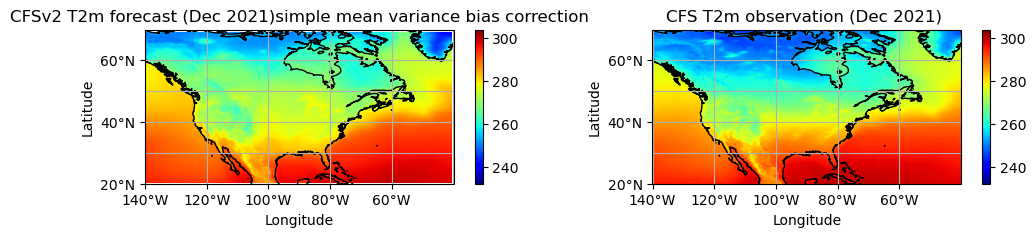

In [16]:

t2m_smv = xr.DataArray(T_2021_corrected, dims=('lat', 'lon'), coords={'lat': t2m_cfsr.lat, 'lon':t2m_cfsr.lon})

fig, axs = plt.subplots(1, 2, figsize=(12, 2), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot original T2m forecast
t2m_smv.plot(ax=axs[0], cmap='jet', vmin=232, vmax=304)
axs[0].set_title('CFSv2 T2m forecast (Dec 2021)simple mean variance bias correction')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
xticks = range(-140, -40, 20)
yticks = range(20, 70, 20)
axs[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[0].coastlines()
axs[0].gridlines()


file = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas.202112.grib2"
grbs = pygrib.open(file)
t2m = grbs.select(name='2 metre temperature')[0]
t2m_data = t2m.values
lats, lons = t2m.latlons()
grbs.close()
t2m_cfsr_2021 = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                sel(lon=slice(220, 320), lat=slice(70, 20))
t2m_cfsr_2021.plot(ax=axs[1], cmap='jet', vmin=232, vmax=304)
axs[1].set_title('CFS T2m observation (Dec 2021) ')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[1].coastlines()
axs[1].gridlines()

axs

In [17]:
t2m_cfsr_2021_new  = t2m_cfsr_2021.interp(lon=t2m_smv.lon, lat=t2m_smv.lat, method='linear')
y_hat = t2m_smv.values.flatten()
y =  t2m_cfsr_2021_new.values.flatten() 
mask = (~np.isnan(y_hat)) & (~np.isnan(y)) 
pattern_corr = np.corrcoef(y_hat[mask], y[mask])[0, 1]
mean_diff = y_hat[mask]-y[mask]
rmse = np.sqrt(np.mean(mean_diff**2))
print(f"The pattern correlation for simple mean and variance bias correction is {pattern_corr:.3f}")
print(f"The rmse for simple mean and variance bias correction is {rmse:.3f}")

The pattern correlation for simple mean and variance bias correction is 0.971
The rmse for simple mean and variance bias correction is 4.395


# Q3

(1)-(3) are same as Q2 

(4) Construct the CDF for each grid point for t2m_o  / construct the inverse function 

In [18]:
# Create a 2D array t2m_o with dimensions (year, lat, lon)
t2m_o_inversecdf = np.empty((t2m_o.shape[1], t2m_o.shape[2]), dtype=object)
for i in range(t2m_o_inversecdf.shape[0]):
    for j in range(t2m_o_inversecdf.shape[1]):
        sample = t2m_o[:, i, j]
        tmp  = sm.distributions.ECDF(sample)
        # Evaluate the ECDF at a set of values
        x = np.linspace(min(sample), max(sample))
        y = tmp(x)
        t2m_o_inversecdf[i, j] = interp1d(y, x, bounds_error=False)

(5) Construct the CDF for each grid point for t2m_f

In [19]:
# Create a 2D array t2m_o with dimensions (year, lat, lon)
t2m_f_cdf = np.empty((t2m_f.shape[1], t2m_f.shape[2]), dtype=object)
for i in range(t2m_f_cdf.shape[0]):
    for j in range(t2m_f_cdf.shape[1]):
        t2m_f_cdf[i, j] = sm.distributions.ECDF(t2m_f[:, i, j])

(6) Carry out the quantile mapping at each grid point for 𝑇"#"$ , and 𝑇)"#"$ denotes
the bias-corrected T2m forecast

In [20]:
T_2021_corrected_quantile = np.zeros(T_2021.shape)
for i in range(T_2021.shape[0]):
    for j in range(T_2021.shape[1]):
        if  t2m_o_inversecdf[i,j](t2m_f_cdf[i,j](T_2021[i, j])) <0:
            print(t2m_f_cdf[i,j](T_2021[i, j]))
            print(i)
            print(j)
        T_2021_corrected_quantile[i,j] = t2m_o_inversecdf[i,j](t2m_f_cdf[i,j](T_2021[i, j]))

(7) Plot 𝑇)"#"$ and the monthly mean T2m in Dec 2021 from the CFSR side by side,
and calculate the RMSE and pattern correlation between the two.

array([<GeoAxesSubplot: title={'center': 'CFSv2 T2m forecast (Dec 2021) quantile mapping bias correction'}, xlabel='Longitude', ylabel='Latitude'>,
       <GeoAxesSubplot: title={'center': 'CFS T2m observation (Dec 2021) '}, xlabel='Longitude', ylabel='Latitude'>],
      dtype=object)

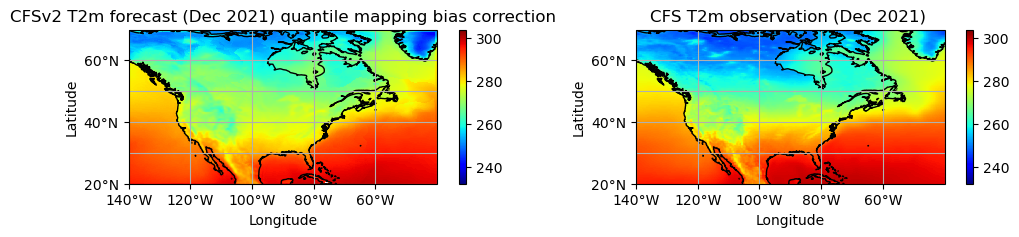

In [21]:
t2m_qm = xr.DataArray(T_2021_corrected_quantile, dims=('lat', 'lon'), coords={'lat': t2m_cfsr.lat, 'lon':t2m_cfsr.lon})

fig, axs = plt.subplots(1, 2, figsize=(12, 2), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot original T2m forecast
t2m_qm.plot(ax=axs[0], cmap='jet', vmin=232, vmax=304)
axs[0].set_title('CFSv2 T2m forecast (Dec 2021) quantile mapping bias correction')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
xticks = range(-140, -40, 20)
yticks = range(20, 70, 20)
axs[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[0].coastlines()
axs[0].gridlines()


file = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas.202112.grib2"
grbs = pygrib.open(file)
t2m = grbs.select(name='2 metre temperature')[0]
t2m_data = t2m.values
lats, lons = t2m.latlons()
grbs.close()
t2m_cfsr_2021 = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                sel(lon=slice(220, 320), lat=slice(70, 20))
t2m_cfsr_2021.plot(ax=axs[1], cmap='jet', vmin=232, vmax=304)
axs[1].set_title('CFS T2m observation (Dec 2021) ')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[1].coastlines()
axs[1].gridlines()

axs

In [22]:
t2m_cfsr_2021_new  = t2m_cfsr_2021.interp(lon=t2m_qm.lon, lat=t2m_qm.lat, method='linear')
y_hat = t2m_qm.values.flatten()
y =  t2m_cfsr_2021_new.values.flatten() 
mask = (~np.isnan(y_hat)) & (~np.isnan(y)) 
pattern_corr = np.corrcoef(y_hat[mask], y[mask])[0, 1]
mean_diff = y_hat[mask]-y[mask]
rmse = np.sqrt(np.mean(mean_diff**2))
print(f"The pattern correlation for quantile mapping bias correction method is {pattern_corr:.3f}")
print(f"The rmse for quantile mapping bias correction method is {rmse:.3f}")

The pattern correlation for quantile mapping bias correction method is 0.976
The rmse for quantile mapping bias correction method is 4.081


# Q4

(1)Calculate the long-term mean monthly mean H500 and Ps in Dec during 1982-
2010 using the 6-hourly data from the CFSv2 reforecasts initiated at 0000 UTC
Nov 2 in each year from 1982 to 2010.

In [23]:
h500_cfsv2_list = []
for year in range(1982, 2011):
    h500_list = []
    print(year)
    h500_cfsv2_names = "/data/zhuowang/c/zhuowang/Data/CFSv2/"+str(year)+"/pgbf*"
    h500_cfsv2_list_names = glob.glob(h500_cfsv2_names)
    # Loop over ethe cfsv2_list
    for file  in h500_cfsv2_list_names:
        grbs = pygrib.open(file)
        h500 = grbs.select(name='Geopotential Height', level = 500)[0]
        h500_data = h500.values
        lats, lons = h500.latlons()
        grbs.close()
        h500_tmp = xr.DataArray(h500_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
        h500_list.append(h500_tmp)

    h500_cfsv2_list.append(xr.concat(h500_list, dim="time").mean(dim="time").\
                        sel(lon=slice(180, 340), lat=slice(75, 15)))

1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [24]:
h500_cfsv2_mean= xr.concat(h500_cfsv2_list, dim="time").mean(dim="time")

In [25]:
pr_cfsv2_list = []
for year in range(1982, 2011):
    pr_list = []
    print(year)
    pr_cfsv2_names = "/data/zhuowang/c/zhuowang/Data/CFSv2/"+str(year)+"/pgbf*"
    pr_cfsv2_list_names = glob.glob(pr_cfsv2_names)
    # Loop over ethe cfsv2_list
    for file  in pr_cfsv2_list_names:
        grbs = pygrib.open(file)
        pr = grbs.select(name='Pressure',level = 0)[0]
        pr_data = pr.values
        lats, lons = pr.latlons()
        grbs.close()
        pr_tmp = xr.DataArray(pr_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
        pr_list.append(pr_tmp)

    pr_cfsv2_list.append(xr.concat(pr_list, dim="time").mean(dim="time").\
                         sel(lon=slice(180, 340), lat=slice(75, 15)))


1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [26]:
pr_cfsv2_mean= xr.concat(pr_cfsv2_list, dim="time").mean(dim="time")

(2)Calculate the monthly mean H500 and Ps in December, 2021 using the 6-hourly
data from the CFSv2 operational initiated at 0000 UTC Nov 2, 2021, and calculate
the monthly mean anomalies by removing the corresponding long-term monthly
mean in Dec derived from the CFSv2 reforecasts derived in the previous step.

In [27]:
h500_list = []
h500_cfsv2_names = "/data/zhuowang/c/zhuowang/Data/CFSv2/2021/pgbf*"
h500_cfsv2_list_names = glob.glob(h500_cfsv2_names)
# Loop over ethe cfsv2_list
for file  in h500_cfsv2_list_names:
    grbs = pygrib.open(file)
    h500 = grbs.select(name='Geopotential Height', level = 500)[0]
    h500_data = h500.values
    lats, lons = h500.latlons()
    grbs.close()
    h500_tmp = xr.DataArray(h500_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
    h500_list.append(h500_tmp)

h500_cfsv2_2021 = xr.concat(h500_list, dim="time").mean(dim="time").\
        sel(lon=slice(180, 340), lat=slice(75, 15))

h500_cfsv2_anomalies= h500_cfsv2_2021-h500_cfsv2_mean

In [28]:
pr_list = []
pr_cfsv2_names = "/data/zhuowang/c/zhuowang/Data/CFSv2/2021/pgbf*"
pr_cfsv2_list_names = glob.glob(pr_cfsv2_names)
# Loop over ethe cfsv2_list
for file  in pr_cfsv2_list_names:
    grbs = pygrib.open(file)
    pr = grbs.select(name='Pressure',level = 0)[0]
    pr_data = pr.values
    lats, lons = pr.latlons()
    grbs.close()
    pr_tmp = xr.DataArray(pr_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]})
    pr_list.append(pr_tmp)

pr_cfsv2_2021 = xr.concat(pr_list, dim="time").mean(dim="time").\
        sel(lon=slice(180, 340), lat=slice(75, 15))
pr_cfsv2_anomalies= pr_cfsv2_2021-pr_cfsv2_mean

(3)Calculate the monthly mean H500 and Ps in Jan, Feb, Nov and Dec during 1979-
2010 from the CFS reanalysis (there are 32*4=128 months). Calculate the
monthly mean anomalies by removing the corresponding long-term mean
monthly mean over 1979-2010.


In [29]:
h500_cfsr_list = []
for year in range(1979, 2011):
    for month in ["01","02","11","12"]:
        cfsr_file_name = "/data/zhuowang/c/zhuowang/Data/CFSR/pgbhnl.gdas."+str(year)+str(month)+".grb2"
        grbs = pygrib.open(cfsr_file_name)
        h500 = grbs.select(name='Geopotential Height', level = 500)[0]
        h500_data = h500.values
        lats, lons = h500.latlons()
        grbs.close()
        h500_cfsr = xr.DataArray(h500_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).sel(lon=slice(180, 340), lat=slice(75, 15))
        h500_cfsr_list.append(h500_cfsr)
h500_cfsr_jan_mean =  xr.concat(h500_cfsr_list[::4], dim="time").mean(dim="time").\
                        sel(lon=slice(180, 340), lat=slice(75, 15))
h500_cfsr_feb_mean =xr.concat(h500_cfsr_list[1::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
h500_cfsr_nov_mean = xr.concat(h500_cfsr_list[2::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
h500_cfsr_dec_mean = xr.concat(h500_cfsr_list[3::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))

h500_cfsr_3d= np.zeros((128, len(h500_cfsr_list[0].lat), len(h500_cfsr_list[0].lon)))
for i in range(0,128):
    if i % 4 == 0:
        h500_cfsr_3d[i, :, :] = h500_cfsr_list[i] - h500_cfsr_jan_mean
    elif i % 4 == 1: 
        h500_cfsr_3d[i, :, :] = h500_cfsr_list[i] - h500_cfsr_feb_mean
    elif i % 4 == 2: 
        h500_cfsr_3d[i, :, :] = h500_cfsr_list[i] - h500_cfsr_nov_mean
    else:
        h500_cfsr_3d[i, :, :] = h500_cfsr_list[i] - h500_cfsr_dec_mean

In [30]:
pr_cfsr_list = []
for year in range(1979, 2011):
    for month in ["01","02","11","12"]:
        cfsr_file_name = "/data/zhuowang/c/zhuowang/Data/CFSR/pgbhnl.gdas."+str(year)+str(month)+".grb2"
        grbs = pygrib.open(cfsr_file_name)
        pr = grbs.select(name='Pressure',level = 0)[0]
        pr_data = pr.values
        lats, lons = pr.latlons()
        grbs.close()
        pr_cfsr = xr.DataArray(pr_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
        pr_cfsr_list.append(pr_cfsr)
pr_cfsr_jan_mean =  xr.concat(pr_cfsr_list[::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
pr_cfsr_feb_mean =xr.concat(pr_cfsr_list[1::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
pr_cfsr_nov_mean = xr.concat(pr_cfsr_list[2::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))
pr_cfsr_dec_mean = xr.concat(pr_cfsr_list[3::4], dim="time").mean(dim="time").\
                    sel(lon=slice(180, 340), lat=slice(75, 15))

pr_cfsr_3d= np.zeros((128, len(pr_cfsr_list[0].lat), len(pr_cfsr_list[0].lon)))
for i in range(0,128):
    if i % 4 == 0:
        pr_cfsr_3d[i, :, :] = pr_cfsr_list[i] - pr_cfsr_jan_mean
    elif i % 4 == 1: 
        pr_cfsr_3d[i, :, :] = pr_cfsr_list[i] - pr_cfsr_feb_mean
    elif i % 4 == 2: 
        pr_cfsr_3d[i, :, :] = pr_cfsr_list[i] - pr_cfsr_nov_mean
    else:
        pr_cfsr_3d[i, :, :] = pr_cfsr_list[i] - pr_cfsr_dec_mean

(4) Please calculate the pattern correlations of H500 and Ps monthly mean
anomalies between the CFSv2 forecast in Dec 2021 and the CFS reanalysis in
each of the 128 months. Although one can assign different weights to H500 and
Ps, we will take the sum of the H500 and Ps pattern correlations for simplicity.


In [31]:
pcorr = np.zeros(128)
for i in range(128):
        # Assuming x and y are 2D arrays with the same shape
    x_1 =  h500_cfsr_3d[i, :, :].flatten()
    y_1 = h500_cfsv2_anomalies.\
            interp(lat=h500_cfsr_list[0].lat, lon=h500_cfsr_list[1].lon, method='linear').\
            values.flatten()
    
    x_2 =  pr_cfsr_3d[i, :, :].flatten()
    y_2 = pr_cfsv2_anomalies.\
            interp(lat=pr_cfsr_list[0].lat, lon=pr_cfsr_list[1].lon, method='linear').\
            values.flatten()
    # Calculate correlation coefficient
    pcorr[i] = np.corrcoef(x_1, y_2)[0, 1]  + np.corrcoef(x_2, y_2)[0, 1]


(5)Please select three months with the highest pattern correlation sums. The
averaged T2m over those months from the CFSR can be regarded as the forecast
for Dec 2021. Please plot this average (i.e., your forecast) along with the T2m in
Dec 2021 from the CFSR (i.e., the corresponding observation), and calculate the
RMSE and pattern correlation between the two.


In [32]:
# get the 128 month t2m
t2m_cfsr_list = []
for year in range(1979, 2011):
    for month in ["01","02","11","12"]:
        cfsr_file_name = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas."+str(year)+str(month)+".grb2"
        grbs = pygrib.open(cfsr_file_name)
        t2m = grbs.select(name='2 metre temperature')[0]
        t2m_data = t2m.values
        lats, lons = t2m.latlons()
        grbs.close()
        t2m_cfsr = xr.DataArray(t2m_data, dims=('lat', 'lon'), coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                sel(lon=slice(220, 320), lat=slice(70, 20))
        t2m_cfsr_list.append(t2m_cfsr)

In [33]:
t2m_cfsr_3d= np.zeros((3, len(t2m_cfsr_list[0].lat), len(t2m_cfsr_list[0].lon)))
indices = np.argsort(pcorr)[-3:]
for i in range(3):
    t2m_cfsr_3d[i, :, :] = t2m_cfsr_list[indices[i]]

array([<GeoAxesSubplot: title={'center': 'CFSv2 T2m forecast (Dec 2021) analogue'}, xlabel='Longitude', ylabel='Latitude'>,
       <GeoAxesSubplot: title={'center': 'CFS T2m observation (Dec 2021) '}, xlabel='Longitude', ylabel='Latitude'>],
      dtype=object)

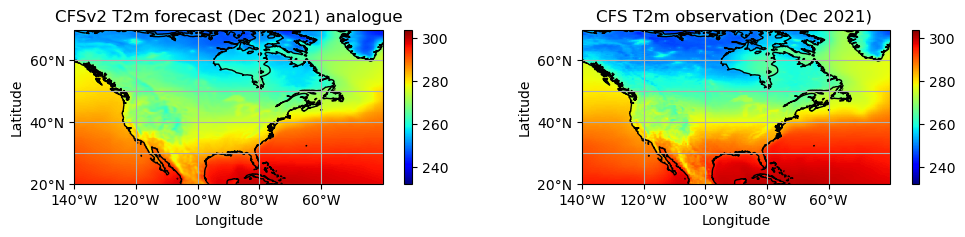

In [34]:
t2m_analogue = xr.DataArray(np.mean(t2m_cfsr_3d, axis=0), dims=('lat', 'lon'), \
                            coords={'lat': t2m_cfsr_list[0].lat, 'lon':t2m_cfsr_list[0].lon})

fig, axs = plt.subplots(1, 2, figsize=(12, 2), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot original T2m forecast
t2m_analogue.plot(ax=axs[0], cmap='jet', vmin=232, vmax=304)
axs[0].set_title('CFSv2 T2m forecast (Dec 2021) analogue')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
xticks = range(-140, -40, 20)
yticks = range(20, 70, 20)
axs[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[0].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[0].coastlines()
axs[0].gridlines()


file = "/data/zhuowang/c/zhuowang/Data/CFSR/flxf01.gdas.202112.grib2"
grbs = pygrib.open(file)
t2m = grbs.select(name='2 metre temperature')[0]
t2m_data = t2m.values
lats, lons = t2m.latlons()
grbs.close()
t2m_cfsr_2021 = xr.DataArray(t2m_data, dims=('lat', 'lon'),\
                             coords={'lat': lats[:, 0], 'lon': lons[0, :]}).\
                    sel(lon=slice(220, 320), lat=slice(70, 20))
t2m_cfsr_2021.plot(ax=axs[1], cmap='jet', vmin=232, vmax=304)
axs[1].set_title('CFS T2m observation (Dec 2021) ')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axs[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axs[1].xaxis.set_major_formatter(cticker.LongitudeFormatter())
axs[1].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axs[1].coastlines()
axs[1].gridlines()

axs

In [35]:
t2m_cfsr_2021_new  = t2m_cfsr_2021.\
                interp(lon=t2m_qm.lon, lat=t2m_qm.lat, method='linear')
y_hat = t2m_analogue.values.flatten()
y =  t2m_cfsr_2021_new.values.flatten() 
mask = (~np.isnan(y_hat)) & (~np.isnan(y)) 
pattern_corr = np.corrcoef(y_hat[mask], y[mask])[0, 1]
mean_diff = y_hat[mask]-y[mask]
rmse = np.sqrt(np.mean(mean_diff**2))
print(f"The pattern correlation for quantile mapping bias correction method is {pattern_corr:.3f}")
print(f"The rmse for quantile mapping bias correction method is {rmse:.3f}")

The pattern correlation for quantile mapping bias correction method is 0.979
The rmse for quantile mapping bias correction method is 3.388
